In [ ]:
!/usr/local/cuda/bin/nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Tue_Jun_12_23:07:04_CDT_2018
Cuda compilation tools, release 9.2, V9.2.148


In [ ]:
%%writefile multMatrixGeneric.cu
/*
Descricao: multiplicacao de matrizes em paralelo usando GPU
Entrada: dimensao das matrizes e dos blocos de threads
Saida: tempos de execucao
Restricoes: por simplificacao, matrizes quadradas inicializadas para teste.
            A dimensao das matrizes e dos blocos deve ser potencia de 2.  
*/

#include <stdio.h>
//para tomada de tempo
#include <sys/time.h>
//o agumento dee ser double
#define BLOCK_SIZE 16
#define GET_TIME(now) { \
   struct timespec time; \
   clock_gettime(CLOCK_MONOTONIC_RAW, &time); \
   now = time.tv_sec + time.tv_nsec/1000000000.0; \
  }



//para checar erros chamadas Cuda
#define CUDA_SAFE_CALL(call) { \
   cudaError_t err = call;     \
   if(err != cudaSuccess) {    \
      fprintf(stderr,"Erro no arquivo '%s', linha %i: %s.\n",__FILE__, __LINE__,cudaGetErrorString(err)); \
      exit(EXIT_FAILURE); } } 

//funcao para execucao sequencial
void multMatSeq(double *a, double *b, double *c, int rowA,int colA,int colB) {
   int i, j, k;
   double soma;
   for(i=0; i<rowA; i++)
      for(j=0; j<colB; j++) {
         soma = 0;
         for(k=0; k<colA; k++) {
            soma += a[i*colA+k] * b[k*colB+j];
         }
         c[i*colB+j] = soma;
      }
}


//Kernel de multiplicacao de matrizes genéricas com memória compartilhada
__global__ void multMatriz(double *a,double *b, double *c, int colunasA, int colunasB) {
     
//coordenadas globais da thread
int i = blockIdx.x * blockDim.x + threadIdx.x;
int j = blockIdx.y * blockDim.y + threadIdx.y;
    
//coordenadas locais da thread
int i_bloco = threadIdx.x;
int j_bloco = threadIdx.y;


int tam_bloco = BLOCK_SIZE;
    
//memoria compartilhada para a submatriz de A
__shared__ double Asub[BLOCK_SIZE][BLOCK_SIZE];
//memoria compartilhada para a submatriz de B
__shared__ double Bsub[BLOCK_SIZE][BLOCK_SIZE];
    
//calcula o elemento C(i,j)
    
double valor = 0;

for(int passo=0; passo<colunasA; passo+=tam_bloco) {
  //cada thread carrega um elemento de A e B
  Asub[i_bloco][j_bloco] = a [(i * colunasA) + (passo + j_bloco)];
  Bsub[i_bloco][j_bloco] = b[(passo + i_bloco)*colunasB + j];
  //sincroniza para terminar a copia
  __syncthreads();
  //cada thread computa um elemento
  for (int k = 0; k < tam_bloco; k++) {
  valor += Asub[i_bloco][k] * Bsub[k][j_bloco];
  }
  //sincroniza para terminar a computacão
  __syncthreads();
}
    
//escreve o valor calculado na matriz de saida
c[i*colunasB +j] = valor;
    
}


//funcao que aloca espaco para uma matriz e preenche seus valores
//entrada: matriz de entrada, dimensoes da matriz
//saida: retorna 1 se a matriz foi preenchida com sucesso e 0 caso contrario
int preencheMatriz(double **mat, int linhas, int colunas) {
   int i, j;
   //aloca espaco de memoria para a matriz
   *mat = (double*) malloc(sizeof(double) * linhas * colunas);
   if (mat == NULL) return 0;
   //preenche o vetor
   for (i=0; i<linhas; i++) {
      for (j=0; j<colunas; j++) {
         *((*mat) + (i*colunas+j)) = 1.5;
      }
   }
   return 1;
}

//funcao que imprime uma matriz
//entrada: matriz de entrada, dimensoes da matriz
//saida: matriz impressa na tela
void imprimeMatriz(double *mat, int linhas, int colunas, FILE *arq) {
   int i, j;
   for (i=0; i<linhas; i++) {
       
      for (j=0; j<colunas; j++) {
         fprintf(arq, "%.1f ", mat[i*colunas+j]);
      }
      fprintf(arq, "\n");
   }
}

//funcao principal
int main(int argc, char** argv) {
   double *h_a, *h_b, *h_c, *h_c_par; //matrizes host
   double *d_a, *d_b, *d_c; //matrizes device
   //para medidas de tempo
   double inicio, fim;
   double tempo_seq, tempo_par_ini, tempo_par_fim;
   cudaEvent_t start, stop;
   long int n_bytes; //qtde bytes por matriz
   unsigned int tam_bloco = BLOCK_SIZE;
  
   int real_linhasA;
	 int real_linhasB;
	 int real_colunasA;
	 int real_colunasB;
    
   
    
	if(argc != 5){
		printf("Modo de uso: %s <Linhas Matriz A> <Colunas Matriz A> <Linhas Matriz B> <Colunas Matriz B>\n", argv[0]);
		exit(-1);
	}else{
		real_linhasA  = atoi(argv[1]);
		real_colunasA = atoi(argv[2]);
		real_linhasB  = atoi(argv[3]);
		real_colunasB = atoi(argv[4]);

		if(real_colunasA != real_linhasB){
			printf("Erro: Colunas A != Linhas B\n");
			exit(-1);
		}
  }
   int linhasA;
	 int linhasB;
	 int colunasA;
   int colunasB;
  
 //Completa as linhas e colunas para serem múltiplas de block_size
    linhasA  = real_linhasA  +BLOCK_SIZE - (real_linhasA  % BLOCK_SIZE);
    colunasA = real_colunasA + BLOCK_SIZE- (real_colunasA % BLOCK_SIZE);

	  linhasB  = real_linhasB  + BLOCK_SIZE - (real_linhasB  % BLOCK_SIZE);
	  colunasB = real_colunasB + BLOCK_SIZE - (real_colunasB % BLOCK_SIZE);

    n_bytes = linhasA * colunasB * sizeof(double);
    
   /*if(preencheMatriz(&h_a, linhasA, colunasA) == 0) {
      fprintf(stderr, "Erro de preenchimento da matriz de entrada A\n");
      exit(EXIT_FAILURE);
   }

   //aloca e preenche a matriz de entrada B
   if(preencheMatriz(&h_b, linhasB, colunasB) == 0) {
      fprintf(stderr, "Erro de preenchimento da matriz de entrada B\n");
      exit(EXIT_FAILURE);
   }
    */
   //aloca a matriz de saida (versao sequencial)
   h_c = (double*) malloc(n_bytes);
   if(h_c==NULL) {
      fprintf(stderr, "Erro de alocacao da matriz de saida\n");
      exit(EXIT_FAILURE);
   }
   //aloca a matriz de saida (versao paralela)
   h_c_par = (double*) malloc(n_bytes);
   if(h_c_par==NULL) {
      fprintf(stderr, "Erro de alocacao da matriz de saida\n");
      exit(EXIT_FAILURE);
   }
    
    
    h_a = (double *) malloc(linhasA * colunasA * sizeof(double));
    h_b = (double *) malloc(linhasB * colunasB * sizeof(double));
    
    //Inicializa os vetores no host
	for(int i = 0; i < linhasA * colunasA; i++){

		if(i%colunasA < real_linhasA || i%linhasA < real_colunasA){
			h_a[i] = (double) 1.0;
		}else{
			//Preenche com zeros o que completamos anteriormente
			h_a[i] = 0;
		}	
	}

	//Inicializa os vetores no host
	for(int i = 0; i < linhasB * colunasB; i++){
		if(i%colunasB < real_linhasB || i%linhasB < real_colunasB){
			h_b[i] = (double) 1.0;
		}else{
			//Preenche com zeros o que completamos anteriormente
			h_b[i] = 0;
		}	
	} 

    
   //!!! ------------------------ executa sequencial ---------------------------------- !!!//
   GET_TIME(inicio);
   multMatSeq(h_a, h_b, h_c, linhasA,colunasA,colunasB);
   GET_TIME(fim);

   tempo_seq = fim-inicio; // calcula o tempo sequencial em segundos
   

   //!!! ------------------------ executa em paralelo em CUDA -------------------------- !!!//
   GET_TIME(inicio);
   //aloca espaco para as matrizes na GPU
   CUDA_SAFE_CALL(cudaMalloc((void**) &d_a, linhasA * colunasA * sizeof(double)));
   CUDA_SAFE_CALL(cudaMalloc((void**) &d_b, linhasB * colunasB * sizeof(double)));
   CUDA_SAFE_CALL(cudaMalloc((void**) &d_c, n_bytes));

   //copia as matrizes de entrada da CPU para a GPU (host para device)
   CUDA_SAFE_CALL(cudaMemcpy(d_a, h_a, linhasA * colunasA * sizeof(double), cudaMemcpyHostToDevice));
   CUDA_SAFE_CALL(cudaMemcpy(d_b, h_b, linhasB * colunasB * sizeof(double) , cudaMemcpyHostToDevice));

   //invoca o kernel com blocos de tamanhos fixos
   dim3 threadsBloco = {tam_bloco, tam_bloco};
   dim3 blocosGrade = {linhasA/threadsBloco.x, colunasB/threadsBloco.y};
   
   GET_TIME(fim);
   tempo_par_ini = fim-inicio; // calcula o tempo das inicializacoes paralelo em segundos
   
   printf("kernel com (%d,%d) blocos de (%d,%d) threads\n", blocosGrade.x, blocosGrade.y, threadsBloco.x, threadsBloco.y);
 
    
   //dispara o kernel
   CUDA_SAFE_CALL(cudaEventCreate(&start));
   CUDA_SAFE_CALL(cudaEventCreate(&stop));
   CUDA_SAFE_CALL(cudaEventRecord(start));
   multMatriz<<<blocosGrade, threadsBloco>>>(d_a, d_b, d_c, colunasA,colunasB);
   CUDA_SAFE_CALL(cudaGetLastError());
   CUDA_SAFE_CALL(cudaEventRecord(stop));
   CUDA_SAFE_CALL(cudaEventSynchronize(stop));
   double delta_eventos = 0;
   CUDA_SAFE_CALL(cudaEventElapsedTime(&delta_eventos, start, stop));

   //copia resultado da GPU para a CPU (device para host)
   GET_TIME(inicio);
   CUDA_SAFE_CALL(cudaMemcpy(h_c_par, d_c, n_bytes, cudaMemcpyDeviceToHost))
   GET_TIME(fim);
   tempo_par_fim = fim-inicio; // calcula o tempo das finalizacoes paralelo em segundos
   
   //verifica se o resultado esta correto
   /*for (int i=0; i<linhasA; i++) {
      for (int j=0; j<colunasB; j++) {
            if (fabs(h_c[i*linhasA+j] - h_c_par[i*linhasA+j]) > 1e-5) {
                printf("%f", h_c[i*linhasA+j]);
                printf("- %f", h_c_par[i*linhasA+j]);
               fprintf(stderr, "resultado incorreto\n");
               exit(EXIT_FAILURE);
             }
      }
   }*/
   
   /*
   printf("%d ", linhasA);
   printf("%d - ", colunasB);
   printf("\nMatriz de saida C (sequencial):\n");
   imprimeMatriz(h_c, linhasA , colunasB, stdout);
    
   printf("\nMatriz de saida C (paralelo):\n");
   //imprimeMatriz(h_c_par, linhasA , colunasB, stdout); */
    
   for(int i = 0; i < linhasA * colunasB; i++){
      if(fabs(h_c[i] - h_c_par[i]) > 0.1){
     
          
          printf("%f ", h_c[i]);
          printf("- %f", h_c_par[i]);
          printf(" -- %d",i);
        fprintf(stderr, "resultado incorreto\n");
        exit(EXIT_FAILURE);
      }
   }
   
   printf("PASSOU NO TESTE\n");

   //libera a memoria na GPU
   CUDA_SAFE_CALL(cudaFree(d_a));
   CUDA_SAFE_CALL(cudaFree(d_b));
   CUDA_SAFE_CALL(cudaFree(d_c));

   //libera a memoria na CPU
   free(h_a);
   free(h_b);
   free(h_c);
   free(h_c_par);

   //------------------------------- imprime dos tempos de execucao ----------------------//
   printf("Tempo sequencial      = %g seg \n", tempo_seq);
   
   printf("Tempo paralelo kernel = %f seg \n", delta_eventos/1000);
   printf("Tempo paralelo inicio = %f seg \n", tempo_par_ini);
   printf("Tempo paralelo fim    = %f seg \n", tempo_par_fim);
   printf("Tempo paralelo total  = %f seg \n", tempo_par_ini+(delta_eventos/1000)+tempo_par_fim);
   
   printf("\nAceleracao  = %f\n", tempo_seq/(tempo_par_ini+(delta_eventos/1000)+tempo_par_fim));

   return 0;
}

Overwriting multMatrixGeneric.cu


In [ ]:
!/usr/local/cuda/bin/nvcc -o multMatrixGeneric multMatrixGeneric.cu

In [ ]:
!./multMatrixGeneric 1024 1024 1024 1024

kernel com (65,65) blocos de (16,16) threads
PASSOU NO TESTE
Tempo sequencial      = 4.68185 seg 
Tempo paralelo kernel = 0.039870 seg 
Tempo paralelo inicio = 0.098829 seg 
Tempo paralelo fim    = 0.003714 seg 
Tempo paralelo total  = 0.142413 seg 

Aceleracao  = 32.875165


In [ ]:
%%writefile readMatrix.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
//para tomada de tempo
#include <sys/time.h>
//o agumento dee ser double
#define BLOCK_SIZE 16
#define GET_TIME(now) { \
   struct timespec time; \
   clock_gettime(CLOCK_MONOTONIC_RAW, &time); \
   now = time.tv_sec + time.tv_nsec/1000000000.0; \
  }

//para checar erros chamadas Cuda
#define CUDA_SAFE_CALL(call) { \
   cudaError_t err = call;     \
   if(err != cudaSuccess) {    \
      fprintf(stderr,"Erro no arquivo '%s', linha %i: %s.\n",__FILE__, __LINE__,cudaGetErrorString(err)); \
      exit(EXIT_FAILURE); } } 

  
void imprimeMatriz(double *mat, int linhas, int colunas, FILE *arq) {
   int i, j;
   for (i=0; i<linhas; i++) {
       
      for (j=0; j<colunas; j++) {
         fprintf(arq, "%.3f ", mat[i*colunas+j]);
      }
      fprintf(arq, "\n");
   }
}

//Kernel de multiplicacao de matrizes genéricas com memória compartilhada
__global__ void multMatriz(double *a,double *b, double *c, int colunasA, int colunasB) {
     
//coordenadas globais da thread
int i = blockIdx.x * blockDim.x + threadIdx.x;
int j = blockIdx.y * blockDim.y + threadIdx.y;
    
//coordenadas locais da thread
int i_bloco = threadIdx.x;
int j_bloco = threadIdx.y;


int tam_bloco = BLOCK_SIZE;
    
//memoria compartilhada para a submatriz de A
__shared__ double Asub[BLOCK_SIZE][BLOCK_SIZE];
//memoria compartilhada para a submatriz de B
__shared__ double Bsub[BLOCK_SIZE][BLOCK_SIZE];
    
//calcula o elemento C(i,j)
    
double valor = 0;

for(int passo=0; passo<colunasA; passo+=tam_bloco) {
  //cada thread carrega um elemento de A e B
  Asub[i_bloco][j_bloco] = a [(i * colunasA) + (passo + j_bloco)];
  Bsub[i_bloco][j_bloco] = b[(passo + i_bloco)*colunasB + j];
  //sincroniza para terminar a copia
  __syncthreads();
  //cada thread computa um elemento
  for (int k = 0; k < tam_bloco; k++) {
  valor += Asub[i_bloco][k] * Bsub[k][j_bloco];
  }
  //sincroniza para terminar a computacão
  __syncthreads();
}
    
//escreve o valor calculado na matriz de saida
c[i*colunasB +j] = valor;
    
}

void imprimeMatrizColuna(double *mat, int linhas, int colunas,int size, FILE *arq) {
   int i, j;
   for (j=0; j<colunas; j++) {
       
      for (i=0; i<linhas; i++) {
         fprintf(arq, "%.3f ", mat[i*size+j]);
      }
      fprintf(arq, "\n");
   }
}

/*
void multMatSeq(double *a, double *b, double *c, int rowA,int colA,int colB) {
   int i, j, k;
   double soma;
   for(i=0; i<rowA; i++)
      for(j=0; j<colB; j++) {
         soma = 0;
         for(k=0; k<colA; k++) {
            soma += a[i*colA+k] * b[k*colB+j];
            
            //printf("Iterador %d ",k*colB+j);
            //printf("Valor B: %f ",b[k*colB+j]);
            //printf("Valor A: %f ",a[i*colA+k]);
            //printf("Soma: %f col_a:%d row_a:%d col_b:%d row_b:%d \n", soma,k,i,j,k);
             
         }
         //printf("\n");
         c[i*colB+j] = soma;
      }
} */


void multMatSeq(double *a, double *b, double *c, int rowA,int colA,int colB) {
   
   double *h_a, *h_b, *h_c, *h_c_par; //matrizes host
   double *d_a, *d_b, *d_c; //matrizes device
    
    //para medidas de tempo
   double inicio, fim;
   double tempo_par_ini, tempo_par_fim;
   cudaEvent_t start, stop;
   long int n_bytes; //qtde bytes por matriz
   unsigned int tam_bloco = BLOCK_SIZE;
    
   int real_linhasA=rowA;
	 int real_linhasB=colA;
	 int real_colunasA=colA;
	 int real_colunasB=colB;
    
   int linhasA;
	 int linhasB;
	 int colunasA;
   int colunasB;
    
   //Completa as linhas e colunas para serem múltiplas de block_size
   linhasA  = real_linhasA  +BLOCK_SIZE - (real_linhasA  % BLOCK_SIZE);
   colunasA = real_colunasA + BLOCK_SIZE- (real_colunasA % BLOCK_SIZE);

   linhasB  = real_linhasB  + BLOCK_SIZE - (real_linhasB  % BLOCK_SIZE);
   colunasB = real_colunasB + BLOCK_SIZE - (real_colunasB % BLOCK_SIZE);
   
    //printf("Linha A: %d , Coluna A: %d \n",linhasA,colunasA );
    //printf("Real Linha A: %d , Coluna A: %d \n",real_linhasA,real_colunasA );
    
    //printf("Linha B: %d , Coluna B: %d \n",linhasB,colunasB );
    //printf("Real Linha B: %d , Coluna B: %d \n",real_linhasB,real_colunasB );
    
   n_bytes = linhasA * colunasB * sizeof(double);
   
   h_c = (double*) malloc(n_bytes);
   if(h_c==NULL) {
      fprintf(stderr, "Erro de alocacao da matriz de saida\n");
      exit(EXIT_FAILURE);
   }
   //aloca a matriz de saida (versao paralela)
   h_c_par = (double*) malloc(n_bytes);
   if(h_c_par==NULL) {
      fprintf(stderr, "Erro de alocacao da matriz de saida\n");
      exit(EXIT_FAILURE);
   }
    
    h_a = (double *) malloc(linhasA * colunasA * sizeof(double));
    h_b = (double *) malloc(linhasB * colunasB * sizeof(double));
    
    //Inicializa os vetores no host
   
    //printf("\nMatrizes Reais: \n");
    //imprimeMatriz(a,real_linhasA,real_colunasA,stdout);
    //printf("\n\n");
     //imprimeMatriz(b,real_linhasB,real_colunasB,stdout);
    //printf("\n\n");
    
    for(int i = 0; i < linhasA ; i++){
        for(int j=0; j<colunasA;j++){
           //printf("\n");
		if(i < real_linhasA && j < real_colunasA){
       //printf("Valor A[%d][%d] = %f \n",i,j, a[i * real_linhasA + j] );
			h_a[i*colunasA+j] = a[i * real_colunasA + j];
		}else{
			//Preenche com zeros o que completamos anteriormente
			h_a[i*colunasA+j] = 0;
		}	 
        }
    
	}
   
  
   
    
      //printf("\n");
	//Inicializa os vetores no host
	for(int i = 0; i < linhasB; i++){
      for(int j=0; j< colunasB ; j++){
          //printf("\n");
		if(i < real_linhasB && j < real_colunasB){
       //printf("Norm Valor B[%d][%d] = %f \n",i,j, b[i * real_linhasB + j] );
			h_b[i*colunasB+j] = b[i*real_colunasB+j];
		}else{ 
      //printf(" Else Valor B[%d][%d] = %f \n",i,j, 0.0 );
			//Preenche com zeros o que completamos anteriormente
			h_b[i*colunasB+j] = 0;
		}	
      }
      
	} 
    
    //printf("\nMatrizes: \n");
    //imprimeMatriz(h_a,linhasA,colunasA,stdout);
    //printf("\n\n");
     //imprimeMatriz(h_b,linhasB,colunasB,stdout);
    
    //!!! ------------------------ executa em paralelo em CUDA -------------------------- !!!//
   GET_TIME(inicio);
   //aloca espaco para as matrizes na GPU
   CUDA_SAFE_CALL(cudaMalloc((void**) &d_a, linhasA * colunasA * sizeof(double)));
   CUDA_SAFE_CALL(cudaMalloc((void**) &d_b, linhasB * colunasB * sizeof(double)));
   CUDA_SAFE_CALL(cudaMalloc((void**) &d_c, n_bytes));

   //copia as matrizes de entrada da CPU para a GPU (host para device)
   CUDA_SAFE_CALL(cudaMemcpy(d_a, h_a, linhasA * colunasA * sizeof(double), cudaMemcpyHostToDevice));
   CUDA_SAFE_CALL(cudaMemcpy(d_b, h_b, linhasB * colunasB * sizeof(double) , cudaMemcpyHostToDevice));

   //invoca o kernel com blocos de tamanhos fixos
   dim3 threadsBloco = {tam_bloco, tam_bloco};
   dim3 blocosGrade = {linhasA/threadsBloco.x, colunasB/threadsBloco.y};
   
   GET_TIME(fim);
   tempo_par_ini = fim-inicio; // calcula o tempo das inicializacoes paralelo em segundos
   
   //printf("kernel com (%d,%d) blocos de (%d,%d) threads\n", blocosGrade.x, blocosGrade.y, threadsBloco.x, threadsBloco.y);
 
    
   //dispara o kernel
   CUDA_SAFE_CALL(cudaEventCreate(&start));
   CUDA_SAFE_CALL(cudaEventCreate(&stop));
   CUDA_SAFE_CALL(cudaEventRecord(start));
   multMatriz<<<blocosGrade, threadsBloco>>>(d_a, d_b, d_c, colunasA,colunasB);
   CUDA_SAFE_CALL(cudaGetLastError());
   CUDA_SAFE_CALL(cudaEventRecord(stop));
   CUDA_SAFE_CALL(cudaEventSynchronize(stop));
   float delta_eventos = 0.0;
   CUDA_SAFE_CALL(cudaEventElapsedTime(&delta_eventos, start, stop));

   //copia resultado da GPU para a CPU (device para host)
   GET_TIME(inicio);
   CUDA_SAFE_CALL(cudaMemcpy(h_c_par, d_c, n_bytes, cudaMemcpyDeviceToHost))
   GET_TIME(fim);
   tempo_par_fim = fim-inicio; // calcula o tempo das finalizacoes paralelo em segundos
    
    //!!! ------------------------ Fim execução paralela -------------------------- !!!//

   
    for(int i = 0; i < linhasA * colunasB; i++){
        for(int j=0; j<colunasB;j++){
         		if(i < real_linhasA && j < real_colunasB){
              c[i*real_colunasB+j] = h_c_par[i*colunasB+j];
            }   
        }	
	} 
    

    //printf("\nMatrizes B: \n");
    //imprimeMatriz(b,real_linhasB,real_colunasB,stdout);
   //libera a memoria na GPU
   CUDA_SAFE_CALL(cudaFree(d_a));
   CUDA_SAFE_CALL(cudaFree(d_b));
   CUDA_SAFE_CALL(cudaFree(d_c));

   //libera a memoria na CPU
   free(h_a);
   free(h_b);
   free(h_c);
   free(h_c_par);
    
   
}

void multMatSeqPrint(double *a, double *b, double *c, int rowA,int colA,int colB) {
   int i, j, k;
   double soma;
   for(i=0; i<rowA; i++)
      for(j=0; j<colB; j++) {
         soma = 0;
         for(k=0; k<colA; k++) {
            soma += a[i*colA+k] * b[k*colB+j];
            
            printf("Iterador %d ",k*colB+j);
            printf("Valor B: %f ",b[k*colB+j]);
            printf("Valor A: %f ",a[i*colA+k]);
            printf("Soma: %f col_a:%d row_a:%d col_b:%d row_b:%d \n", soma,k,i,j,k);
             
         }
         printf("\n");
         c[i*colB+j] = soma;
      }
}

double vector_norm(double *a, int row){
    double soma;
    int i;
    for(i=0;i<row;i++){
        soma += pow(a[i],2);
    }
    
   return sqrt(soma);    
}

void pot(double *matrix,double *_vec_aux, int row, int col){
    
    double norm,norm_old,diff;
    
    norm = 0;
    diff = 1;
    int n = row;
    int m = col; 
    
    double *_random_vec = (double*)malloc(m*sizeof(double));
    
    
    
    for(int i=0; i<n;i++){
        _random_vec[i] = (double) 1.0;
    }
    
    
      
    
    while(diff > 1e-20){
        
        norm_old = norm;

        multMatSeq(matrix,_random_vec,_vec_aux,n,m,1);

        norm = vector_norm(_vec_aux,m);

        diff = norm - norm_old;

        diff = pow(diff,2);
        
        //printf("Diff: %f ", diff);

        //imprimeMatriz(_random_vec,m,1,stdout);
        //printf("\n");
        //printf("Norm: %f \n",norm);
        //imprimeMatriz(_vec_aux,m,1,stdout);
        //printf("\n");

        if(norm>0){
          for(int i=0;i<m;i++){
              //printf("%.2f ",_vec_aux[i]);
              
            _random_vec[i] = _vec_aux[i]/norm;
              
              
              //printf(" %.2f ",_random_vec[i]);
              //printf("\n");
          }
            //printf("\n\n\n");
         }
    
        //imprimeMatriz(_random_vec,m,1,stdout);
        //printf("\n");
        
    }
    
    //printf("\nFechou\n");
    
    for(int i=0;i<m;i++){
       _vec_aux[i] = _random_vec[i];
    }
    
    free(_random_vec);
    
}

void transpose(double *a, double*b,int n,int m){
    for(int i=0; i<n;i++){
       for(int j=0;j<m;j++){          
        b[i*n+j] = a[j*n+i];     
      }
    }
    
}

void eig_a_t_a(double *_matrix_a, double *_eigen_vec_matrix,double *_eigen_val_matrix, int row, int col,int *col_eig){
    int n = row;
    int m = col; 
    double mean =1;
    double old_mean,mean_diff;
    double aux_mean=0;
    
    int col_eig_vec = 0;
    
    int n_bytes = n*m*sizeof(double);
    
    double *_matrix_aux = (double*)malloc(n_bytes);
    double *_matrix_T = (double*)malloc(n_bytes);
    
    double *_vec_aux = (double*)malloc(m*sizeof(double)); 
    
    double *_vec_eig_aux = (double*)malloc(m*sizeof(double));
    
    double *_matrix_eig_aux_diff = (double*)malloc(n_bytes);
    
    double *_value_aux = (double*)malloc(m*sizeof(double));
    
    transpose(_matrix_a,_matrix_T,n,m);
    
    multMatSeq(_matrix_T,_matrix_a,_matrix_aux,n,m,n);
    
    while(mean > 1e-3){
                    //old_mean = aux_mean;
                    mean = 0;
                    
                    //printf("Chamei metodo da pot: \n");
                    //printf("Matriz é essa: \n");
                    //imprimeMatriz(_matrix_aux,n,m,stdout);
                    
                    //printf("\nComeçou Pot: \n");
                    pot(_matrix_aux,_vec_aux,n,m);

                    for(int i=0; i<m;i++){
                      _eigen_vec_matrix[i*m + col_eig_vec] = _vec_aux[i];
                    }

                    //printf("\n V metodo pot:");    
                    //imprimeMatriz(_vec_aux,m,1,stdout);
                    //printf("\n Coluna: %d",col_eig_vec);

                    col_eig_vec++;    


                    //imprimeMatriz(_matrix_aux,m,n,stdout);
                    //printf("\n");

                    for(int j=0;j<col_eig_vec;j++){
                       for(int i=0; i<m;i++){
                           _vec_aux[i] = _eigen_vec_matrix[i*m + j];           
                      }
                      //printf("\n V dentro do loop: \n");
                      //imprimeMatriz(_vec_aux,m,1,stdout);
                     // printf("\n");

                        for(int i=0;i<m;i++){
                            _vec_eig_aux[i]=0.0;
                        }

                        for(int i=0;i<n*m;i++){
                            _matrix_eig_aux_diff[i]=0.0;
                        }

                      multMatSeq(_matrix_aux,_vec_aux,_vec_eig_aux,n,m,1);

                      //printf("\n Vec dentro do loop: \n");
                      //imprimeMatriz(_vec_eig_aux,m,1,stdout);

                      //printf("\n");
                      multMatSeq(_vec_eig_aux,_vec_aux,_matrix_eig_aux_diff,m,1,m);
                      //printf("\n Matriz Diff: \n");  
                      //imprimeMatriz(_matrix_eig_aux_diff,n,m,stdout);
                      //printf("\n");  

                       for(int k=0; k<n*m;k++){
                           _matrix_aux[k] = _matrix_aux[k] - _matrix_eig_aux_diff[k];

                       }

                       //printf("\n Matriz Parcial Result: \n");  
                       //imprimeMatriz(_matrix_aux,n,m,stdout);

                    }

                    for(int k=0; k<n*m;k++){
                           mean += _matrix_aux[k];           
                       }

                    mean = mean/(m*n);
                    aux_mean = mean;
                    mean_diff = mean - old_mean ;
                    //mean = pow(mean_diff,2);
                    printf("\nMedia: %.10lf \n",mean);
                    //printf("\n Matriz Final Result: \n");  
                    //imprimeMatriz(_matrix_aux,n,m,stdout);
                    //printf("\n");
                    //printf("\n\n\n ENTREI AQUI \n\n\n");

                    }
    
   //printf("\n\n\n ENTREI AQUI 2 \n\n\n");
    
   multMatSeq(_matrix_T,_matrix_a,_matrix_aux,n,m,n);
    
   for(int j=0;j<col_eig_vec;j++){
       for(int i=0; i<m;i++){
           _vec_aux[i] = _eigen_vec_matrix[i*m + j];           
      }
       //printf("\n V dentro do loop: \n");
      //imprimeMatriz(_vec_aux,m,1,stdout);
       
       multMatSeq(_matrix_aux,_vec_aux,_vec_eig_aux,n,m,1);
       
       //transpose(_vec_aux,_vec_T,m,1);
       
       //multMatSeq(_vec_T,_vec_eig_aux,_value_aux,1,m,1);
       
       multMatSeq(_vec_aux,_vec_eig_aux,_value_aux,1,m,1);
       
       //imprimeMatriz(_value_aux,1,1,stdout);
       //printf("\nEig val:");
       _eigen_val_matrix[j*m+j] = _value_aux[0];
       //printf("\n");
       
   }  
    
    
    free(_matrix_aux);
    free(_matrix_T);
    free(_vec_aux);
    free(_vec_eig_aux);    
    free(_matrix_eig_aux_diff);
    free(_value_aux);
    
    *col_eig = col_eig_vec;
}

void SVD(double *_matrix_a,int row, int col,char s){
    int n = row;
    int m = col;
    
    FILE * f_v;
    FILE * f_sig;
    FILE * f_u;
    
    int n_bytes = n*m*sizeof(double);
    
    double *_matrix_copy = (double*)malloc(n_bytes);
    
    double *_v_matrix = (double*)malloc(n_bytes);
    
    double *_sig_2_matrix = (double*)malloc(n_bytes);
    
    double *_sig_matrix = (double*)malloc(n_bytes);
    
    double *_u_sig_matrix = (double*)malloc(n_bytes);
    
    double *_u_matrix_T = (double*)malloc(n_bytes);
    
    double *_u_matrix = (double*)malloc(n_bytes);
    
    double norm;
    
    double *_u_vec = (double*)malloc(m*sizeof(double));
      
    int col_eig_vec = 0;   
    
    char nome_arquivo_v[32];
    
    snprintf(nome_arquivo_v, sizeof(char) * 32, "v_%c.txt",s);
    
    char nome_arquivo_sig[32];
    
    snprintf(nome_arquivo_sig, sizeof(char) * 32, "sig_%c.txt",s);
    
    char nome_arquivo_u[32];
    
    snprintf(nome_arquivo_u, sizeof(char) * 32, "u_%c.txt",s);
    
    f_v = fopen(nome_arquivo_v, "w");
    f_sig = fopen(nome_arquivo_sig, "w");
    f_u = fopen(nome_arquivo_u, "w");
    
    if(f_v == NULL)
        exit(EXIT_FAILURE);
    
    if(f_sig == NULL)
        exit(EXIT_FAILURE);
    
    if(f_u == NULL)
        exit(EXIT_FAILURE);
    
    for (int i=0; i<m*n;i++){
        _matrix_copy[i] = _matrix_a[i];
    }
        
    printf("\nComeçou Eig: \n");
    eig_a_t_a(_matrix_copy,_v_matrix,_sig_2_matrix,n,m,&col_eig_vec);
    
    
    //printf("\nEigen");
    //printf("\n");
    printf("%d",col_eig_vec);
    
    for(int j=0;j<col_eig_vec;j++){
      //printf("\n Coluna atual: %d\n",j);
      for(int i=0;i<n;i++){
          //printf("%.3f \n",_v_matrix[i*n+j]);
          
      }
    }
    
    for(int j=0;j<col_eig_vec;j++){
      //printf("\n Coluna atual: %d\n",j); 
      for(int i=0;i<col_eig_vec;i++){
          //printf("%.3f \n",_sig_2_matrix[i*n+j]);
          
      }
        
    }
    
    
    
    //printf("\n\n\n Mult:");
    multMatSeq(_matrix_a,_v_matrix,_u_sig_matrix,n,m,n);
    //printf("\n\n\n Usig:");
    //imprimeMatriz(_u_sig_matrix,n,m,stdout);
    
    for(int j=0;j<col_eig_vec;j++){
      //printf("\n Coluna atual: %d\n",j);
      for(int i=0;i<m;i++){
          _u_vec[i] = _u_sig_matrix[i*n+j];
          
          //printf("%.3f \n",_u_sig_matrix[i*n+j]);         
      }
        printf("\n");
        //imprimeMatriz(_u_vec,m,1,stdout);
        
        norm = vector_norm(_u_vec,m);
        //printf("Norma: %f ", norm);
     
        for(int i=0;i<m;i++){
            
            if (norm>0){
              _u_matrix_T[i*n+j] = _u_sig_matrix[i*n+j]/norm;        
            
            }else{
                _u_matrix_T[i*n+j] = _u_sig_matrix[i*n+j];
            }            
          }
       
       _sig_matrix[j*m+j] = sqrt(_sig_2_matrix[j*m+j]);
      }
    //printf("\n\n\n V: \n");
    imprimeMatrizColuna(_v_matrix,m,col_eig_vec,m,f_v);
   
    transpose(_u_matrix_T,_u_matrix,n,m);

    
    //printf("\n\n\n U: \n");
    imprimeMatrizColuna(_u_matrix,col_eig_vec,m,m,f_u);
   //printf("\n\n\n Sig: \n");
    imprimeMatrizColuna(_sig_matrix,col_eig_vec,col_eig_vec,m,f_sig);
    
    
    fclose(f_v);
    fclose(f_sig);
    fclose(f_u);
    
    free(_matrix_copy);
    free(_v_matrix);
    free(_sig_2_matrix);
    free(_sig_matrix);
    free(_u_sig_matrix);
    free(_u_matrix_T);
    free(_u_matrix);
    free(_u_vec);
    
    
}

int main(void)
{
    FILE * f_r;
    FILE * f_g;
    FILE * f_b;
    
    int n = 512;
    int m = 512;
    
    double inicio, fim;
    double tempo_total;
    
    int n_bytes = n*m*sizeof(double);
    
    double *_matrix_r = (double*)malloc(n_bytes);
    double *_matrix_g = (double*)malloc(n_bytes);
    double *_matrix_b = (double*)malloc(n_bytes);   
    
  
    f_r = fopen("matrix_r.txt", "r");
    f_g = fopen("matrix_g.txt", "r");
    f_b = fopen("matrix_b.txt", "r");
   
    
    if(f_r == NULL)
        exit(EXIT_FAILURE);

    for(int i =0; i<n*m;i++){
        if(!fscanf(f_r,"%lf",&_matrix_r[i]))
          break;
        
    }
    
    if (f_g == NULL)
        exit(EXIT_FAILURE);

    for(int i =0; i<n*m;i++){
        if(!fscanf(f_g,"%lf",&_matrix_g[i]))
          break;
        
    }
    
    if (f_b == NULL)
        exit(EXIT_FAILURE);

    for(int i =0; i<n*m;i++){
        if(!fscanf(f_b,"%lf",&_matrix_b[i]))
          break;
        
    }
   
    //imprimeMatriz(_matrix_r,n,m,stdout);
    printf("\n");
    GET_TIME(inicio);
    SVD(_matrix_r,n,m,'r');
    printf("\nTerminou R \n");
    SVD(_matrix_g,n,m,'g');
    printf("\nTerminou G \n");
    SVD(_matrix_b,n,m,'b');
    printf("\nTerminou B \n");
    GET_TIME(fim);
    
    tempo_total = fim - inicio;
    printf("O tempo total paralelo da execução do SVD tomou: %f segundos", tempo_total);
    
    fclose(f_r);
    fclose(f_g);
    fclose(f_b);
    

    
    exit(EXIT_SUCCESS);
}


Overwriting readMatrix.cu


In [ ]:
!/usr/local/cuda/bin/nvcc -o readMatrix readMatrix.cu

readMatrix.cu(115): warning: variable "tempo_par_ini" was set but never used

readMatrix.cu(115): warning: variable "tempo_par_fim" was set but never used

readMatrix.cu(384): warning: variable "mean_diff" was set but never used

readMatrix.cu(385): warning: variable "aux_mean" was set but never used



In [ ]:
!cat matrix_r.txt

In [ ]:
!./readMatrix



Começou Eig: 

Media: 3810.4267661249 

Media: 398.6316155909 

Media: 97.0816314518 

Media: 70.2948737530 

Media: 70.1727139274 

Media: 5.2799770678 

Media: 2.0812863389 

Media: 1.1429211881 

Media: 0.2192637086 

Media: 0.1430896859 

Media: 0.0481173233 

Media: 0.0319631662 

Media: 0.0306676916 

Media: 0.0006268915 
14














Terminou R 

Começou Eig: 

Media: 2277.3132296802 

Media: 150.0053807659 

Media: 56.3395915735 

Media: 40.3625550743 

Media: 36.1961344844 

Media: 3.6421936675 

Media: 1.4163496245 

Media: 1.0422134718 

Media: 0.1735121531 

Media: 0.0937059544 

Media: 0.0345783089 

Media: 0.0243994126 

Media: 0.0128071196 

Media: 0.0005750307 
14














Terminou G 

Começou Eig: 

Media: 232.3363637264 

Media: 27.2309381381 

Media: 6.2735179185 

Media: 1.0764482120 

Media: 0.9938225566 

Media: 0.1365997886 

Media: 0.1295730486 

Media: 0.0807297522 

Media: 0.0806451222 

Media: 0.0334749161 

Media: 0.0194300697 

Media: 0.000992961

In [ ]:
!cat sig_r.txt

2093020.911 


(32, 32, 3) 



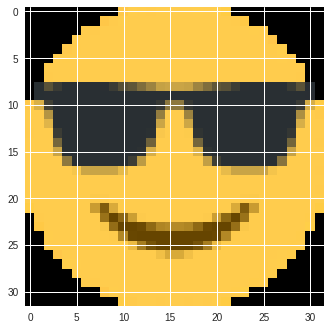

In [ ]:
import argparse
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import requests

# url = 'https://i.imgur.com/R0wKC6t.png'

# url = 'http://optipng.sourceforge.net/pngtech/img/lena.png'

# url = 'https://5.imimg.com/data5/MW/YU/MY-3422441/frp-28x28-square-manhole-cover-250x250.jpg'

# url = 'https://files.incrivel.club/files/news/part_5/56855/preview-906460-1200x630-99-1484645708.jpg'

url = 'https://i.imgur.com/bWopXbp.png'

response = requests.get(url)
# response.content
image = np.asarray(bytearray(response.content), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
print(image.shape,'\n')
# print(image)
b , g ,r = cv2.split(image)

# print(image)
# np.savetxt('matrix_b.txt',b.flatten(),newline=' ',fmt='%d')
# np.savetxt('matrix_g.txt',g.flatten(),newline=' ',fmt='%d')
# np.savetxt('matrix_r.txt',r.flatten(),newline=' ',fmt='%d')

np.savetxt('matrix_b.txt',b,delimiter=' ',fmt='%d')
np.savetxt('matrix_g.txt',g,delimiter=' ',fmt='%d')
np.savetxt('matrix_r.txt',r,delimiter=' ',fmt='%d')

ax1 = plt.subplot(111)
im1 = ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
!cat matrix_r.txt

0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 0 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 255 0 0 0 40 89 58 41 41 41 41 42 59 86 94 126 156 196 201 201 197 157 127 94 87 60 42 41 41 41 41 57 89 40 0 0 40 41 41 41 41 41 41 41 41 41 41

In [ ]:
%%writefile readMatrix.c
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>


  
void imprimeMatriz(double *mat, int linhas, int colunas, FILE *arq) {
   int i, j;
   for (i=0; i<linhas; i++) {
       
      for (j=0; j<colunas; j++) {
         fprintf(arq, "%.3f ", mat[i*colunas+j]);
      }
      fprintf(arq, "\n");
   }
}

void imprimeMatrizColuna(double *mat, int linhas, int colunas,int size, FILE *arq) {
   int i, j;
   for (j=0; j<colunas; j++) {
       
      for (i=0; i<linhas; i++) {
         fprintf(arq, "%.3f ", mat[i*size+j]);
      }
      fprintf(arq, "\n");
   }
}

void multMatSeq(double *a, double *b, double *c, int rowA,int colA,int colB) {
   int i, j, k;
   double soma;
   for(i=0; i<rowA; i++)
      for(j=0; j<colB; j++) {
         soma = 0;
         for(k=0; k<colA; k++) {
            soma += a[i*colA+k] * b[k*colB+j];
            
            //printf("Iterador %d ",k*colB+j);
            //printf("Valor B: %f ",b[k*colB+j]);
            //printf("Valor A: %f ",a[i*colA+k]);
            //printf("Soma: %f col_a:%d row_a:%d col_b:%d row_b:%d \n", soma,k,i,j,k);
             
         }
         //printf("\n");
         c[i*colB+j] = soma;
      }
}

void multMatSeqPrint(double *a, double *b, double *c, int rowA,int colA,int colB) {
   int i, j, k;
   double soma;
   for(i=0; i<rowA; i++)
      for(j=0; j<colB; j++) {
         soma = 0;
         for(k=0; k<colA; k++) {
            soma += a[i*colA+k] * b[k*colB+j];
            
            printf("Iterador %d ",k*colB+j);
            printf("Valor B: %f ",b[k*colB+j]);
            printf("Valor A: %f ",a[i*colA+k]);
            printf("Soma: %f col_a:%d row_a:%d col_b:%d row_b:%d \n", soma,k,i,j,k);
             
         }
         printf("\n");
         c[i*colB+j] = soma;
      }
}

double vector_norm(double *a, int row){
    double soma;
    int i;
    for(i=0;i<row;i++){
        soma += pow(a[i],2);
    }
    
   return sqrt(soma);    
}

void pot(double *matrix,double *_vec_aux, int row, int col){
    
    double norm,norm_old,diff;
    
    norm = 0;
    diff = 1;
    int n = row;
    int m = col; 
    
    double *_random_vec = (double*)malloc(m*sizeof(double));
    
    
    
    for(int i=0; i<n;i++){
        _random_vec[i] = (double) 1.0;
    }
    
    
      
    
    while(diff > 1e-20){
        
        norm_old = norm;

        multMatSeq(matrix,_random_vec,_vec_aux,n,m,1);

        norm = vector_norm(_vec_aux,m);

        diff = norm - norm_old;

        diff = pow(diff,2);
        
        //printf("Diff: %f ", diff);

        //imprimeMatriz(_random_vec,m,1,stdout);
        //printf("\n");
        //printf("Norm: %f \n",norm);
        //imprimeMatriz(_vec_aux,m,1,stdout);
        //printf("\n");

        if(norm>0){
          for(int i=0;i<m;i++){
              //printf("%.2f ",_vec_aux[i]);
              
            _random_vec[i] = _vec_aux[i]/norm;
              
              
              //printf(" %.2f ",_random_vec[i]);
              //printf("\n");
          }
            //printf("\n\n\n");
         }
    
        //imprimeMatriz(_random_vec,m,1,stdout);
        //printf("\n");
        
    }
    
    //printf("\nFechou\n");
    
    for(int i=0;i<m;i++){
       _vec_aux[i] = _random_vec[i];
    }
    
    free(_random_vec);
    
}

void transpose(double *a, double*b,int n,int m){
    for(int i=0; i<n;i++){
       for(int j=0;j<m;j++){          
        b[i*n+j] = a[j*n+i];     
      }
    }
    
}

void eig_a_t_a(double *_matrix_a, double *_eigen_vec_matrix,double *_eigen_val_matrix, int row, int col,int *col_eig){
    int n = row;
    int m = col; 
    double mean =1;
    double old_mean,mean_diff;
    double aux_mean=0;
    
    int col_eig_vec = 0;
    
    int n_bytes = n*m*sizeof(double);
    
    double *_matrix_aux = (double*)malloc(n_bytes);
    double *_matrix_T = (double*)malloc(n_bytes);
    
    double *_vec_aux = (double*)malloc(m*sizeof(double)); 
    
    double *_vec_eig_aux = (double*)malloc(m*sizeof(double));
    
    double *_matrix_eig_aux_diff = (double*)malloc(n_bytes);
    
    double *_value_aux = (double*)malloc(m*sizeof(double));
    
    transpose(_matrix_a,_matrix_T,n,m);
    
    multMatSeq(_matrix_T,_matrix_a,_matrix_aux,n,m,n);
    
    while(mean > 1e-3){
                    //old_mean = aux_mean;
                    mean = 0;
                    
                    //printf("Chamei metodo da pot: \n");
                    //printf("Matriz é essa: \n");
                    //imprimeMatriz(_matrix_aux,n,m,stdout);
                    
                    //printf("\nComeçou Pot: \n");
                    pot(_matrix_aux,_vec_aux,n,m);

                    for(int i=0; i<m;i++){
                      _eigen_vec_matrix[i*m + col_eig_vec] = _vec_aux[i];
                    }

                    //printf("\n V metodo pot:");    
                    //imprimeMatriz(_vec_aux,m,1,stdout);
                    //printf("\n Coluna: %d",col_eig_vec);

                    col_eig_vec++;    


                    //imprimeMatriz(_matrix_aux,m,n,stdout);
                    //printf("\n");

                    for(int j=0;j<col_eig_vec;j++){
                       for(int i=0; i<m;i++){
                           _vec_aux[i] = _eigen_vec_matrix[i*m + j];           
                      }
                      //printf("\n V dentro do loop: \n");
                      //imprimeMatriz(_vec_aux,m,1,stdout);
                     // printf("\n");

                        for(int i=0;i<m;i++){
                            _vec_eig_aux[i]=0.0;
                        }

                        for(int i=0;i<n*m;i++){
                            _matrix_eig_aux_diff[i]=0.0;
                        }

                      multMatSeq(_matrix_aux,_vec_aux,_vec_eig_aux,n,m,1);

                      //printf("\n Vec dentro do loop: \n");
                      //imprimeMatriz(_vec_eig_aux,m,1,stdout);

                      //printf("\n");
                      multMatSeq(_vec_eig_aux,_vec_aux,_matrix_eig_aux_diff,m,1,m);
                      //printf("\n Matriz Diff: \n");  
                      //imprimeMatriz(_matrix_eig_aux_diff,n,m,stdout);
                      //printf("\n");  

                       for(int k=0; k<n*m;k++){
                           _matrix_aux[k] = _matrix_aux[k] - _matrix_eig_aux_diff[k];

                       }

                       //printf("\n Matriz Parcial Result: \n");  
                       //imprimeMatriz(_matrix_aux,n,m,stdout);

                    }

                    for(int k=0; k<n*m;k++){
                           mean += _matrix_aux[k];           
                       }

                    mean = mean/(m*n);
                    aux_mean = mean;
                    mean_diff = mean - old_mean ;
                    //mean = pow(mean_diff,2);
                    printf("\nMedia: %.10lf \n",mean);
                    //printf("\n Matriz Final Result: \n");  
                    //imprimeMatriz(_matrix_aux,n,m,stdout);
                    //printf("\n");
                    //printf("\n\n\n ENTREI AQUI \n\n\n");

                    }
    
   //printf("\n\n\n ENTREI AQUI 2 \n\n\n");
    
   multMatSeq(_matrix_T,_matrix_a,_matrix_aux,n,m,n);
    
   for(int j=0;j<col_eig_vec;j++){
       for(int i=0; i<m;i++){
           _vec_aux[i] = _eigen_vec_matrix[i*m + j];           
      }
       //printf("\n V dentro do loop: \n");
      //imprimeMatriz(_vec_aux,m,1,stdout);
       
       multMatSeq(_matrix_aux,_vec_aux,_vec_eig_aux,n,m,1);
       
       //transpose(_vec_aux,_vec_T,m,1);
       
       //multMatSeq(_vec_T,_vec_eig_aux,_value_aux,1,m,1);
       
       multMatSeq(_vec_aux,_vec_eig_aux,_value_aux,1,m,1);
       
       //imprimeMatriz(_value_aux,1,1,stdout);
       //printf("\nEig val:");
       _eigen_val_matrix[j*m+j] = _value_aux[0];
       //printf("\n");
       
   }  
    
    
    free(_matrix_aux);
    free(_matrix_T);
    free(_vec_aux);
    free(_vec_eig_aux);    
    free(_matrix_eig_aux_diff);
    free(_value_aux);
    
    *col_eig = col_eig_vec;
}

void SVD(double *_matrix_a,int row, int col,char s){
    int n = row;
    int m = col;
    
    FILE * f_v;
    FILE * f_sig;
    FILE * f_u;
    
    int n_bytes = n*m*sizeof(double);
    
    double *_matrix_copy = (double*)malloc(n_bytes);
    
    double *_v_matrix = (double*)malloc(n_bytes);
    
    double *_sig_2_matrix = (double*)malloc(n_bytes);
    
    double *_sig_matrix = (double*)malloc(n_bytes);
    
    double *_u_sig_matrix = (double*)malloc(n_bytes);
    
    double *_u_matrix_T = (double*)malloc(n_bytes);
    
    double *_u_matrix = (double*)malloc(n_bytes);
    
    double norm;
    
    double *_u_vec = (double*)malloc(m*sizeof(double));
      
    int col_eig_vec = 0;   
    
    char nome_arquivo_v[32];
    
    snprintf(nome_arquivo_v, sizeof(char) * 32, "v_%c.txt",s);
    
    char nome_arquivo_sig[32];
    
    snprintf(nome_arquivo_sig, sizeof(char) * 32, "sig_%c.txt",s);
    
    char nome_arquivo_u[32];
    
    snprintf(nome_arquivo_u, sizeof(char) * 32, "u_%c.txt",s);
    
    f_v = fopen(nome_arquivo_v, "w");
    f_sig = fopen(nome_arquivo_sig, "w");
    f_u = fopen(nome_arquivo_u, "w");
    
    if(f_v == NULL)
        exit(EXIT_FAILURE);
    
    if(f_sig == NULL)
        exit(EXIT_FAILURE);
    
    if(f_u == NULL)
        exit(EXIT_FAILURE);
    
    for (int i=0; i<m*n;i++){
        _matrix_copy[i] = _matrix_a[i];
    }
        
    printf("\nComeçou Eig: \n");
    eig_a_t_a(_matrix_copy,_v_matrix,_sig_2_matrix,n,m,&col_eig_vec);
    
    
    //printf("\nEigen");
    //printf("\n");
    printf("%d",col_eig_vec);
    
    for(int j=0;j<col_eig_vec;j++){
      //printf("\n Coluna atual: %d\n",j);
      for(int i=0;i<n;i++){
          //printf("%.3f \n",_v_matrix[i*n+j]);
          
      }
    }
    
    for(int j=0;j<col_eig_vec;j++){
      //printf("\n Coluna atual: %d\n",j); 
      for(int i=0;i<col_eig_vec;i++){
          //printf("%.3f \n",_sig_2_matrix[i*n+j]);
          
      }
        
    }
    
    
    
    //printf("\n\n\n Mult:");
    multMatSeq(_matrix_a,_v_matrix,_u_sig_matrix,n,m,n);
    //printf("\n\n\n Usig:");
    //imprimeMatriz(_u_sig_matrix,n,m,stdout);
    
    for(int j=0;j<col_eig_vec;j++){
      //printf("\n Coluna atual: %d\n",j);
      for(int i=0;i<m;i++){
          _u_vec[i] = _u_sig_matrix[i*n+j];
          
          //printf("%.3f \n",_u_sig_matrix[i*n+j]);         
      }
        printf("\n");
        //imprimeMatriz(_u_vec,m,1,stdout);
        
        norm = vector_norm(_u_vec,m);
        //printf("Norma: %f ", norm);
     
        for(int i=0;i<m;i++){
            
            if (norm>0){
              _u_matrix_T[i*n+j] = _u_sig_matrix[i*n+j]/norm;        
            
            }else{
                _u_matrix_T[i*n+j] = _u_sig_matrix[i*n+j];
            }            
          }
       
       _sig_matrix[j*m+j] = sqrt(_sig_2_matrix[j*m+j]);
      }
    //printf("\n\n\n V: \n");
    imprimeMatrizColuna(_v_matrix,m,col_eig_vec,m,f_v);
   
    transpose(_u_matrix_T,_u_matrix,n,m);

    
    //printf("\n\n\n U: \n");
    imprimeMatrizColuna(_u_matrix,col_eig_vec,m,m,f_u);
   //printf("\n\n\n Sig: \n");
    imprimeMatrizColuna(_sig_matrix,col_eig_vec,col_eig_vec,m,f_sig);
    
    
    fclose(f_v);
    fclose(f_sig);
    fclose(f_u);
    
    free(_matrix_copy);
    free(_v_matrix);
    free(_sig_2_matrix);
    free(_sig_matrix);
    free(_u_sig_matrix);
    free(_u_matrix_T);
    free(_u_matrix);
    free(_u_vec);
    
    
}

int main(void)
{
    FILE * f_r;
    FILE * f_g;
    FILE * f_b;
    
    int n = 512;
    int m = 512;
    
    double inicio,fim;
    double tempo_total;
    int n_bytes = n*m*sizeof(double);
    
    double *_matrix_r = (double*)malloc(n_bytes);
    double *_matrix_g = (double*)malloc(n_bytes);
    double *_matrix_b = (double*)malloc(n_bytes);   
    
  
    f_r = fopen("matrix_r.txt", "r");
    f_g = fopen("matrix_g.txt", "r");
    f_b = fopen("matrix_b.txt", "r");
   
    
    if(f_r == NULL)
        exit(EXIT_FAILURE);

    for(int i =0; i<n*m;i++){
        if(!fscanf(f_r,"%lf",&_matrix_r[i]))
          break;
        
    }
    
    if (f_g == NULL)
        exit(EXIT_FAILURE);

    for(int i =0; i<n*m;i++){
        if(!fscanf(f_g,"%lf",&_matrix_g[i]))
          break;
        
    }
    
    if (f_b == NULL)
        exit(EXIT_FAILURE);

    for(int i =0; i<n*m;i++){
        if(!fscanf(f_b,"%lf",&_matrix_b[i]))
          break;
        
    }
   
    clock_t begin = clock();
    SVD(_matrix_r,n,m,'r');
    SVD(_matrix_g,n,m,'g');
    SVD(_matrix_b,n,m,'b');
    clock_t end = clock();
    
    tempo_total = (double)(end - begin) / CLOCKS_PER_SEC;
    printf("\nO tempo total sequencial da execução do SVD tomou: %f segundos\n", tempo_total);
    printf("\nO tempo total sequencial da execução do SVD tomou: %f minutos", tempo_total/60);
    
    fclose(f_r);
    fclose(f_g);
    fclose(f_b);
    

    
    exit(EXIT_SUCCESS);
}


Overwriting readMatrix.c


In [ ]:
!gcc readMatrix.c -lm -o read

In [ ]:
!rm sig_b.txt

In [ ]:
!cat u_b.txt

In [ ]:
!./read


Começou Eig: 

Media: 1766.0882942201 

Media: 552.3353056546 

Media: 145.8797511186 

Media: 142.7522123481 

Media: 115.2682262140 

Media: 62.8734216621 

Media: 34.2457659041 

Media: 24.8462684517 

Media: 23.7261514706 

Media: 16.5027396042 

Media: 11.4841501207 

Media: 10.9238138795 

Media: 10.4363152086 

Media: 10.4160975695 

Media: 7.0321243886 

Media: 4.7836201794 

Media: 4.5907860020 

Media: 4.3417135976 

Media: 4.1780656337 

Media: 3.5419002643 

Media: 2.9091580941 

Media: 2.8574529492 

Media: 2.6759836181 

Media: 2.0530605581 

Media: 2.0301670588 

Media: 1.0690011049 

Media: 1.0436664892 

Media: 0.9666842835 

Media: 0.9481419616 

Media: 0.8920552345 

Media: 0.8516481704 

Media: 0.8492636208 

Media: 0.8414145211 

Media: 0.8357881649 

Media: 0.8175954384 

Media: 0.7980187012 

Media: 0.7882910972 

Media: 0.7880216769 

Media: 0.6604134788 

Media: 0.6356581032 

Media: 0.6354329587 

Media: 0.6351890464 

Media: 0.6228079782 

Media: 0.622694883

Tempo total SVD:  0.024414539337158203 

[[ 0.172 -0.491  0.256 ...  0.177 -0.527  0.172]
 [-0.043  0.043 -0.052 ... -0.005  0.133 -0.043]
 [-0.041  0.077 -0.021 ... -0.022  0.071 -0.041]
 ...
 [-0.041  0.077 -0.021 ... -0.022  0.071 -0.041]
 [-0.043  0.043 -0.052 ... -0.005  0.133 -0.043]
 [ 0.172 -0.491  0.256 ...  0.177 -0.527  0.172]]
3072
1732


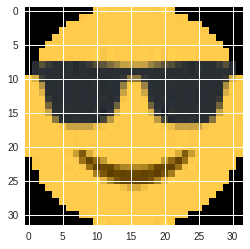

In [ ]:
#Nome: Gabriel Dos Santos Vieira
#DRE: 114029198

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline
from ipywidgets import interact,interactive

def pot(Matrix):
  n = Matrix.shape[1]
  v = np.random.randint(10, size=(n,1))

  #Diferenca ao quadrado entre a norma do vetor na iteracao k+1 e k  (eg: {norm[Vk+1]] - norm[Vk]}**2  )
  diff = 1

  vNormNew = 0

  while (diff > 10**(-20)) :

    # separa a norma da iteracao anterior para comparacao
    vNormOld = vNormNew

    v = np.dot(Matrix,v)
    # pega a norma do novo vetor v
    vNormNew = np.linalg.norm(v)

    #faz a diferenca ao quadrado das normas
    diff = vNormNew - vNormOld
    diff = diff **2
    #print(diff)

    # normaliza o vetor
    if vNormNew != 0:
      v = v/vNormNew


  return v


def eig(Matrix):

  A = Matrix
  A = np.array(A)

  eigenVectors = []
  eigenValues = []

  meanMatrix = 1
  aNew = A
  count = 1

  # quando media dos elementos da matriz for proximo de 0, significa que ja tiramos todos os autovetores de dentro da matriz.
  while (meanMatrix > 10**(-3)):
    v = pot(aNew)
    #print("vetor " + str(count))
    #print(v)
    eigenVectors.append(v)

    # em cada iteracao faz a Matriz A menos a projecao dela em cada um dos autovetores ja encontrados para encontrar o proximo autovetor.
    #for v in eigenVectors:	
      
    vec = np.dot(aNew,v)
    vec = np.dot(vec,v.T)			
    aNew =  aNew - vec


    meanMatrix = np.mean(aNew)

    #utilize para ver o valor da media dos valores da matriz decrescendo a cada rodada
    #print("media dos elementos da matriz A nesta rodada : ")
    #print(meanMatrix)
    #print("")
    #count += 1

  #achando os autovalores com vT * A * v = lambda vTv = lambda
  for vetores in eigenVectors:
    w = np.dot(A,vetores)
    eigenValues.append(np.dot(vetores.T, w))




  # 	l,v = np.linalg.eig(A)

  # 	# ordenando os Auto Valores e Auto Vetores do numpy
  # 	idx = l.argsort()[::-1]
  # 	l = l[idx]
  # 	v = v[:,idx]

  # em caso de comparacao tirar os comentarios do prints abaixo
  #print("numpy eigenVectors")
  #print(v)
  #print("numpy eigenValues")
  #print(l)

  eigenValues = np.array(eigenValues)
  eigenVectors = np.array(eigenVectors)

  return eigenValues, eigenVectors

def svd(matrix):
  #uma matriz e sua decomposição é definida como M = u * sig * v.t
  matrix = np.array(matrix)
  #pegando a matriz e fazendo ela como M.T*M teremos v * sig.t * u.t * u * sig * v.t , como u.t * u = 1 temos  v * sigma2 * v.T 
  m = np.dot(matrix.T,matrix)

  #fazendo os eigenvectors do M.T*M pelo metodo espectral teremos v
  sig2 , v = eig(m)

  #sabemos que M = sigma1 * u1 * v1_t + sigma2 *u2* v2_t + ... , entao se fizermos M*v teremos 
  #M v = sigma* u * v_t * v , como v_t * v = 1 teremos Mv= sigma * u

  uSig = np.dot(matrix,v)
#   print("USIG: \n")
#   print(uSig)
#   print(matrix.shape)
#   print("\n")
#   print(v)
#   print(uSig.shape)
  
  #para retiramos o sigma e ficar apenas com u normalizaremos o vetor Usig
  for col in range(uSig.shape[1]):
    norm_u_sig = np.linalg.norm(uSig[:,col])
    if norm_u_sig  != 0:
      uSig[:,col] /= norm_u_sig
    else:
      uSig[:,col] = uSig[:,col]


  u = uSig[0]
  # apenas um metodo para concatenar as colunas do U
  for n in range(1,uSig.shape[0]):
      u = np.concatenate((u,uSig[n]),axis=1)	
      
      
  # a dimensao da matriz u estava incorreta, estava (m,n) quando deveria ser (n,m)

  u = u.T

  #print "matriz U"
  #print(u)



  vCol = v
  v = vCol[0]
  # apenas um metodo para concatenar as colunas do V
  for n in range(1,vCol.shape[0]):		
      v = np.concatenate((v,vCol[n]),axis =1)


  #corrigindo o mesmo erro da matriz u aonde as colunas estavam no lugar das linhas
  v = v.T

  sigma2 = sig2[0]
  # mesmo problema da concatenacao com o sigma2
  for n in range(1,sig2.shape[0]):
      sigma2 = np.concatenate((sigma2,sig2[n]),axis =0)


  #print "matriz V"
  #print v

  #agora fazendo a raiz quadrada de sigma2
  sigma = np.sqrt(sigma2)
  identity = np.identity(sigma.shape[0])
  sigma = np.multiply(identity,sigma)


  return u,v,sigma



def compress_svd(R,G,B,k):
  
  t0 = time.time()
  u_r,v_r,sigma_r = svd(R)
  u_g,v_g,sigma_g = svd(G)
  u_b,v_b,sigma_b = svd(B)
  t1 = time.time()
  total = t1-t0
  print("Tempo total SVD: ",total,'\n')
  
  w_r = u_r[:,:k].dot(sigma_r[:k,:k].dot(v_r[:k,:]))
  w_b = u_b[:,:k].dot(sigma_b[:k,:k].dot(v_b[:k,:]))
  w_g = u_g[:,:k].dot(sigma_g[:k,:k].dot(v_g[:k,:]))
  
  print(w_r)
  
  np.clip(w_r,0,255,out=w_r)
  np.clip(w_b,0,255,out=w_b)
  np.clip(w_g,0,255,out=w_g)
  
  w_r = np.uint8(w_r)
  w_b = np.uint8(w_b)
  w_g = np.uint8(w_g)
  
  a,b = w_r.shape
  
  w_r = w_r.reshape((a,b,1))
  w_b = w_b.reshape((a,b,1))
  w_g = w_g.reshape((a,b,1))
  
  
  img = np.concatenate((w_b,w_g,w_r),axis=2)
  
  return img


def compress_show(R,G,B,k):
  original_shape = R.shape
  reconst_img = compress_svd(R,G,B,k)
  fig,axes = plt.subplots(1,figsize=(8,5))
  compression_ratio = 100*(k*(original_shape[0]+original_shape[1])+k)/(original_shape[0]*original_shape[1])
  axes.set_title("compression ratio={:.2f}".format(compression_ratio+"%"))
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def main():

  np.set_printoptions(precision=3)
  np.set_printoptions(suppress=True)
  
  R = np.loadtxt('matrix_r.txt', delimiter= ' ')
  G = np.loadtxt('matrix_g.txt', delimiter= ' ')
  B = np.loadtxt('matrix_b.txt', delimiter= ' ')


  t0 = time.time()
  u_r,v_r,sigma_r = svd(R)
  u_g,v_g,sigma_g = svd(G)
  u_b,v_b,sigma_b = svd(B)
  t1 = time.time()
  total = t1-t0
  print("Tempo total SVD: ",total,'\n')
  
#   print("\nR Stuff: \n")
#   print(u_r,'\n',v_r,'\n',sigma_r)
#   print("\nB Stuff: \n")
#   print(u_b,'\n',v_b,'\n',sigma_b)
#   print("\nG Stuff: \n")
#   print(u_g,'\n',v_g,'\n',sigma_g)
  
#   print("\nU R")
#   print(u_r)
#   print("\nV R")
#   print(v_r)
#   print("\n")
#   print((sigma_r.dot(v_r)))
#   print("\nsigma R")
#   print(sigma_r)
#   print("\nMatriz R")
#   R = np.array(R)
#   print(R)
#   print("\n U_r*Sigma_r*V_r_T ")
  
  w_r = u_r.dot(sigma_r.dot(v_r))
  w_b = u_b.dot(sigma_b.dot(v_b))
  w_g = u_g.dot(sigma_g.dot(v_g))
  
  print(w_r)
  
  np.clip(w_r,0,255,out=w_r)
  np.clip(w_b,0,255,out=w_b)
  np.clip(w_g,0,255,out=w_g)
  
  w_r = np.uint8(w_r)
  w_b = np.uint8(w_b)
  w_g = np.uint8(w_g)
  
  a,b = w_r.shape
  
  w_r = w_r.reshape((a,b,1))
  w_b = w_b.reshape((a,b,1))
  w_g = w_g.reshape((a,b,1))
  
  
  img = np.concatenate((w_b,w_g,w_r),axis=2)
  
  
#   img = compress_svd(R,G,B,k)
#   interact(compress_show,R=R,G=G,B=B,k=(1,14))
  
  print(img.nbytes)
  cv2.imwrite("imagem_high_size.jpeg",img)
  print(os.path.getsize('./imagem_high_size.jpeg'))
  ax1 = plt.subplot(111)
  im1 = ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
  
if __name__ == '__main__':
	main()
  

[[ -2.453   4.63  -30.966 ... -30.268   4.759  -2.453]
 [ 33.091 -49.642  25.382 ...  25.132 -49.588  33.091]
 [ -5.569  10.799 -13.126 ... -12.573  10.776  -5.569]
 ...
 [ -5.569  10.799 -13.126 ... -12.573  10.776  -5.569]
 [ 33.091 -49.642  25.382 ...  25.132 -49.588  33.091]
 [ -2.453   4.63  -30.966 ... -30.268   4.759  -2.453]]
3584 1568 3584
1792 392 1792
3072
1657


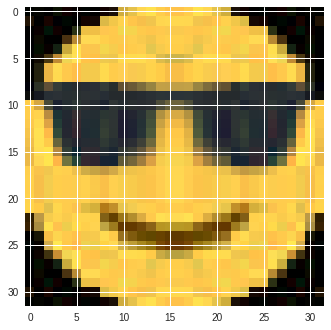

In [ ]:
import os
R = np.loadtxt('matrix_r.txt', delimiter= ' ')
G = np.loadtxt('matrix_g.txt', delimiter= ' ')
B = np.loadtxt('matrix_b.txt', delimiter= ' ')

u_r,v_r,sigma_r = svd(R)
u_g,v_g,sigma_g = svd(G)
u_b,v_b,sigma_b = svd(B)
  
limit = int(sigma_r.shape[0]/2)

w_r = u_r[:,:limit].dot(sigma_r[:limit,:limit].dot(v_r[:limit,:]))
w_b = u_b[:,:limit].dot(sigma_b[:limit,:limit].dot(v_b[:limit,:]))
w_g = u_g[:,:limit].dot(sigma_g[:limit,:limit].dot(v_g[:limit,:]))

print(w_r)

np.clip(w_r,0,255,out=w_r)
np.clip(w_b,0,255,out=w_b)
np.clip(w_g,0,255,out=w_g)

w_r = np.uint8(w_r)
w_b = np.uint8(w_b)
w_g = np.uint8(w_g)

a,b = w_r.shape

w_r = w_r.reshape((a,b,1))
w_b = w_b.reshape((a,b,1))
w_g = w_g.reshape((a,b,1))

print(u_r.nbytes,sigma_r.nbytes , v_r.nbytes )
print(u_r[:,:limit].nbytes ,sigma_r[:limit,:limit].nbytes  , v_r[:limit,:].nbytes )

img = np.concatenate((w_b,w_g,w_r),axis=2)
print(img.nbytes)
cv2.imwrite("imagem_low_size.jpeg",img)
print(os.path.getsize('./imagem_low_size.jpeg'))
ax1 = plt.subplot(111)
im1 = ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

[[225.763 225.763 223.569 ... 231.532 221.518 200.526]
 [225.763 225.763 223.569 ... 231.532 221.518 200.526]
 [225.763 225.763 223.569 ... 231.532 221.518 200.526]
 ...
 [ 82.803  82.803  92.322 ... 173.192 172.576 174.885]
 [ 80.746  80.746  94.356 ... 178.033 178.169 184.256]
 [ 80.746  80.746  94.356 ... 178.033 178.169 184.256]]
786432
273079


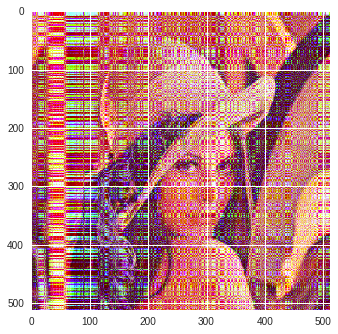

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

def matrix_open(char_name): 
    raw = []
    with open('sig_'+char_name+'.txt','r') as f:
        for line in f:
            raw.append(line.split())

    data = pd.DataFrame(raw)

    sig = np.array(data,dtype=float)

    #print("\n Sig:",sig)

    raw = []
    with open('v_'+char_name+'.txt','r') as f:
        for line in f:
            raw.append(line.split())

    data = pd.DataFrame(raw)

    v = np.array(data,dtype=float)

#     print("\n V:",v)
    raw = []
    with open('u_'+char_name+'.txt','r') as f:
        for line in f:
            raw.append(line.split())

    data = pd.DataFrame(raw)
    u = np.array(data,dtype=float)

#     print("\n U:",u)
    
    return u,v,sig

u_r,v_r,sigma_r = matrix_open('r')
u_g,v_g,sigma_g = matrix_open('g')
u_b,v_b,sigma_b = matrix_open('b')

#limit = int(sigma_r.shape[0])

# w_r = u_r[:,:limit].dot(sigma_r[:limit,:limit].dot(v_r[:limit,:]))
# w_b = u_b[:,:limit].dot(sigma_b[:limit,:limit].dot(v_b[:limit,:]))
# w_g = u_g[:,:limit].dot(sigma_g[:limit,:limit].dot(v_g[:limit,:]))

w_r = u_r.dot(sigma_r.dot(v_r))
w_b = u_b.dot(sigma_b.dot(v_b))
w_g = u_g.dot(sigma_g.dot(v_g))
  
print(w_r)

np.clip(w_r,0,255,out=w_r)
np.clip(w_b,0,255,out=w_b)
np.clip(w_g,0,255,out=w_g)

w_r = np.uint8(w_r)
w_b = np.uint8(w_b)
w_g = np.uint8(w_g)

a,b = w_r.shape

w_r = w_r.reshape((a,b,1))
w_b = w_b.reshape((a,b,1))
w_g = w_g.reshape((a,b,1))


img = np.concatenate((w_b,w_g,w_r),axis=2)
print(img.nbytes)
cv2.imwrite("imagem_low_low_size.jpeg",img)
print(os.path.getsize('./imagem_low_low_size.jpeg'))
ax1 = plt.subplot(111)
im1 = ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
!ls

imagem_low_low_size.jpeg  readMatrix	 sig_g.txt  u_r.txt
matrix_b.txt		  readMatrix.cu  sig_r.txt  v_b.txt
matrix_g.txt		  sample_data	 u_b.txt    v_g.txt
matrix_r.txt		  sig_b.txt	 u_g.txt    v_r.txt


In [ ]:
limit

14

In [ ]:
!stat imagem_high_size.jpeg

  File: imagem_high_size.jpeg
  Size: 1732      	Blocks: 8          IO Block: 4096   regular file
Device: 2dh/45d	Inode: 14943388    Links: 1
Access: (0644/-rw-r--r--)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2018-12-03 18:27:28.831371057 +0000
Modify: 2018-12-03 18:27:28.832371057 +0000
Change: 2018-12-03 18:27:28.832371057 +0000
 Birth: -


In [ ]:
!stat imagem_low_size.jpeg

  File: imagem_low_size.jpeg
  Size: 1657      	Blocks: 8          IO Block: 4096   regular file
Device: 2dh/45d	Inode: 14943389    Links: 1
Access: (0644/-rw-r--r--)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2018-12-03 18:27:34.087376034 +0000
Modify: 2018-12-03 18:27:34.087376034 +0000
Change: 2018-12-03 18:27:34.087376034 +0000
 Birth: -


In [ ]:
!stat imagem_low_low_size.jpeg

  File: imagem_low_low_size.jpeg
  Size: 1655      	Blocks: 8          IO Block: 4096   regular file
Device: 2dh/45d	Inode: 6030547     Links: 1
Access: (0644/-rw-r--r--)  Uid: (    0/    root)   Gid: (    0/    root)
Access: 2018-11-30 18:25:03.676362631 +0000
Modify: 2018-11-30 18:27:38.861217976 +0000
Change: 2018-11-30 18:27:38.861217976 +0000
 Birth: -


If the original image is square, then the matrix representation would require a m2 storage space.
Applying SVD on the original matrix and use only k singular values results in a 2mk + k storage space.
In order to achieve the goal of compression, the k used for the re-constructed image would have to be smaller than m2 / (1+2m). 
In the case of "Lena", the rank used has to be smaller than 255. 

-- http://fourier.eng.hmc.edu/e161/lectures/svdcompression.html

